In [36]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange

"""
Decorator for the function.
It Numba's jit decorator to compile the code into machine language for fast execution
which is useful for computationally intensive tasks like bilinear interpolation.
"""
@jit(nopython=True, fastmath=True, nogil=True, cache=True, parallel=True) 

def bilinear_interpolation(x_in, y_in, f_in, x_out, y_out):
    """
    Perform bilinear interpolation from a 5 km grid to a specified output grid size.
    Parameters:
    x_in (numpy.ndarray): 1D array with x-coordinates of the input grid.
    y_in (numpy.ndarray): 1D array with y-coordinates of the input grid.
    f_in (numpy.ndarray): 2D array with values at input grid points.
    x_out (numpy.ndarray): 1D array with x-coordinates of the output grid.
    y_out (numpy.ndarray): 1D array with y-coordinates of the output grid.

    Returns:
    numpy.ndarray: A 2D array with the interpolated values at output grid points.


    Reference:
    https://stackoverflow.com/questions/8661537/how-to-perform-bilinear-interpolation-in-python
    wikipedia.org/wiki/Bilinear_interpolation

    """
    f_out = np.zeros((y_out.size, x_out.size))
    # Loop over the output grid. Use prange for parallel execution.
    for i in prange(f_out.shape[1]):
        # Find the x-coordinates of the bounding points
        #idx = np.searchsorted(x_in, x_out[i])
        
        # Find the x-coordinates of the bounding points. Ensure idx is within bounds.
        idx = max(1, min(np.searchsorted(x_in, x_out[i]), len(x_in) - 1))

        # Find the x-coordinates of the bounding points
        x1 = x_in[idx-1]
        x2 = x_in[idx]
        x = x_out[i]
        
        # Loop over the y-coordinates
        for j in prange(f_out.shape[0]):
            #idy = np.searchsorted(y_in, y_out[j])
            idy = max(1, min(np.searchsorted(y_in, y_out[j]), len(y_in) - 1))
            y1 = y_in[idy-1]
            y2 = y_in[idy]
            y = y_out[j]

            # Find the values at the four corners
            f11 = f_in[idy-1, idx-1]
            f21 = f_in[idy-1, idx]
            f12 = f_in[idy, idx-1]
            f22 = f_in[idy, idx]
            

            # Perform bilinear interpolation
            f_out[j, i] = ((f11 * (x2 - x) * (y2 - y) +
                            f21 * (x - x1) * (y2 - y) +
                            f12 * (x2 - x) * (y - y1) +
                            f22 * (x - x1) * (y - y1)) /
                           ((x2 - x1) * (y2 - y1)))
    
    return f_out

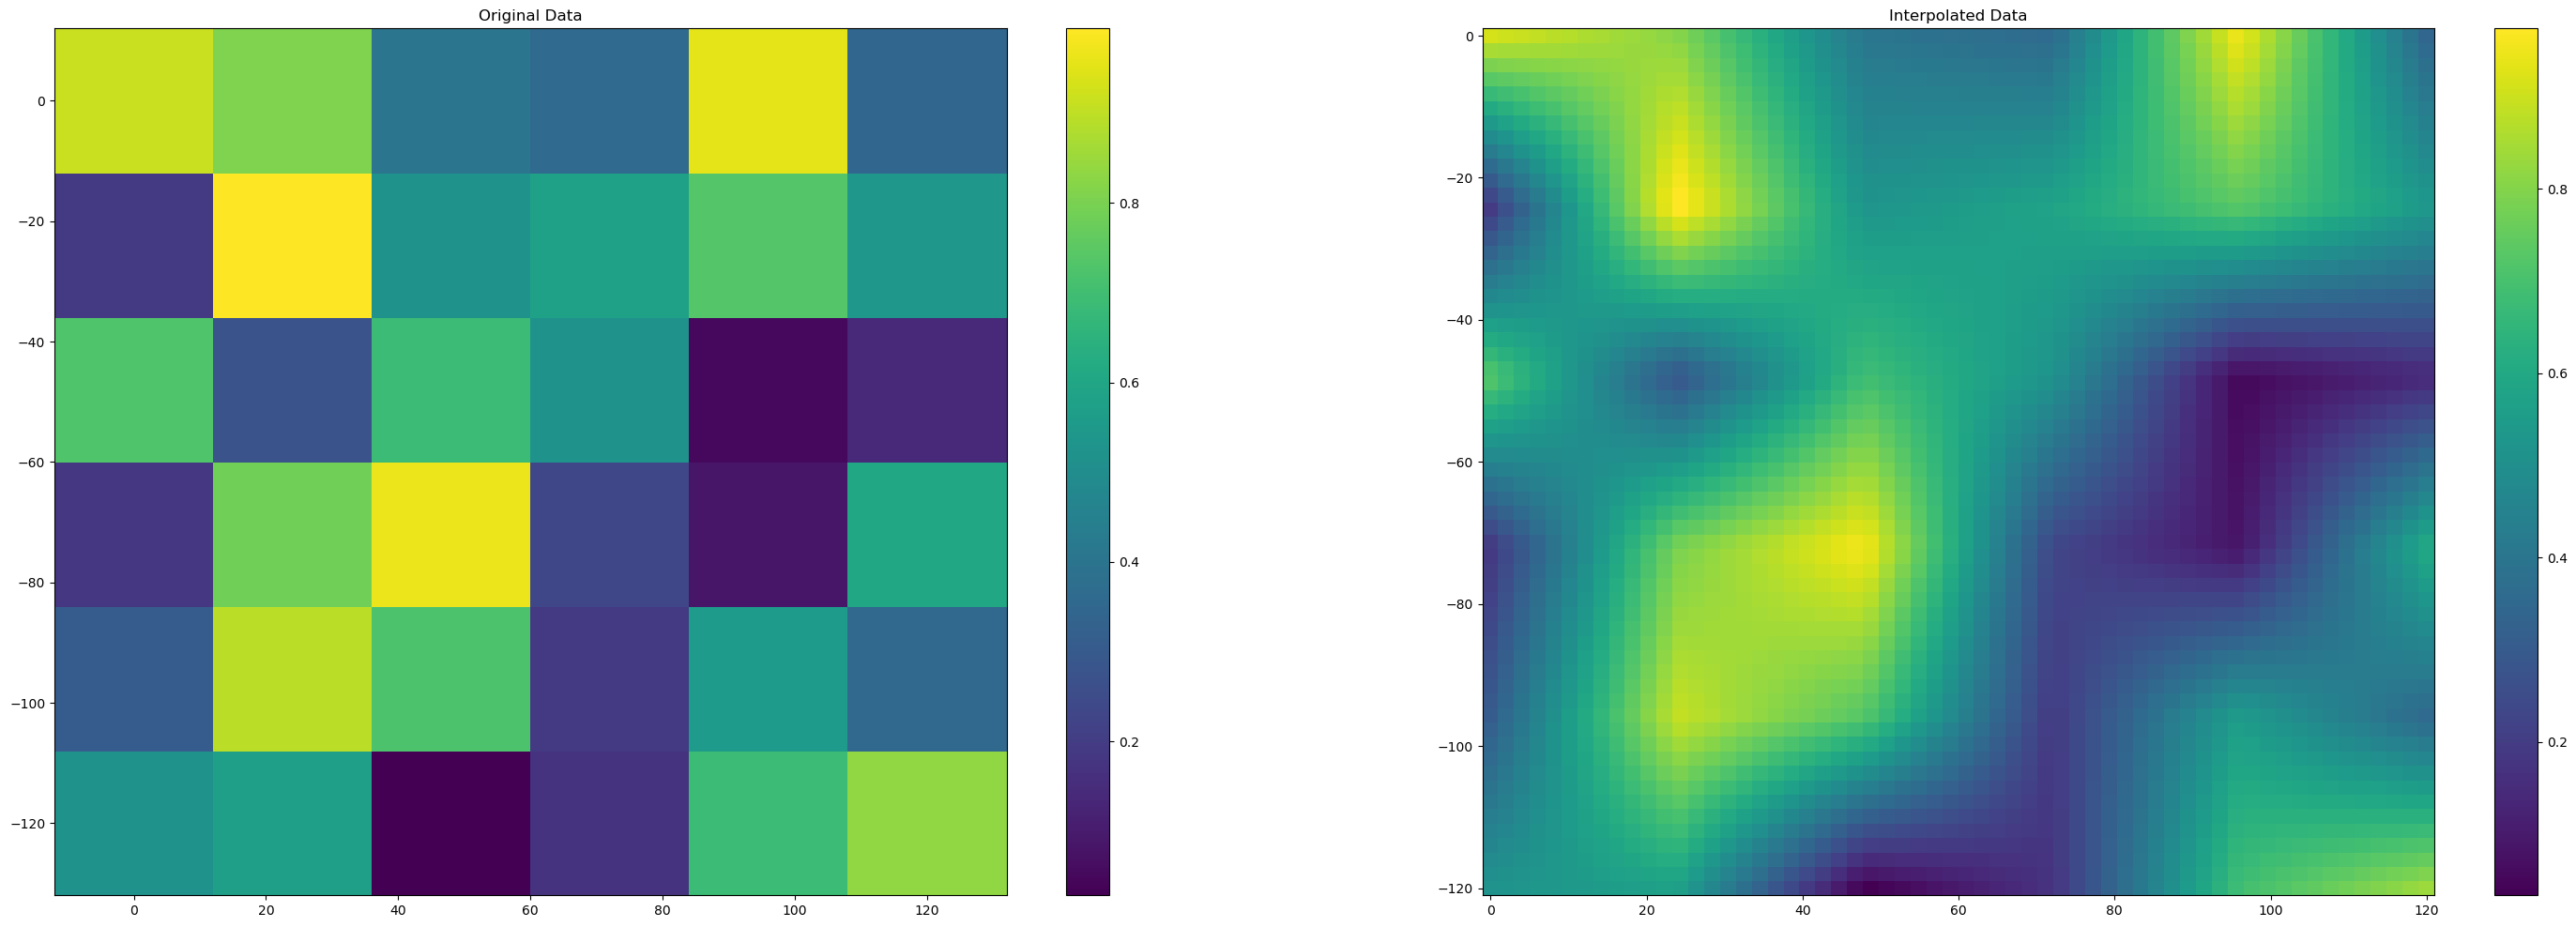

In [47]:
# Define input data grid
x_in = np.linspace(0, 120, 6)  # Input x-coordinates
y_in = np.linspace(-120,0, 6)  # Input y-coordinates
#set a seed for reproducibility
np.random.seed(101)
f_in = np.random.rand(6, 6)   # Random data values at each x_in, y_in coordinate

# Define output grid (where you want to interpolate)
x_out = np.linspace(0, 120, 60)  # Output x-coordinates
y_out = np.linspace(-120,0, 60)  # Output y-coordinates

# Perform bilinear interpolation
f_out = bilinear_interpolation(x_in, y_in, f_in, x_out, y_out)

# Visualizing the results using matplotlib
plt.figure(figsize=(36, 12))

# Plot original data as a mesh
plt.subplot(121)
plt.pcolor(x_in, y_in, f_in, shading='auto')
plt.title('Original Data')
plt.colorbar()

# Plot interpolated data as a mesh
plt.subplot(122)
plt.pcolor(x_out, y_out, f_out, shading='auto')
plt.title('Interpolated Data')
plt.colorbar()

plt.show()

In [44]:
x_in

array([  0.,  24.,  48.,  72.,  96., 120.])

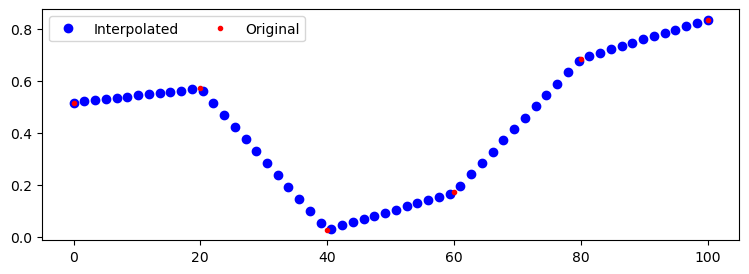

In [211]:
plt.figure(figsize=(9, 3))
plt.plot(x_out, f_out[0],'bo', label='Interpolated',markersize=6)
plt.plot(x_in, f_in[0], 'ro', label='Original', markersize=3)
plt.legend(ncol=2)

(6, 6)